In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.9 
maxh = 0.01

numSheets = 10

dFe = d/numSheets * ff
d0 = d/numSheets * (1-ff)

maxh_edges = d0 * 2


def makeMesh(D, d, ff, numSheets, multiscale=False, modelHalfAir=False):

    


    wp = WorkPlane()
    outer = wp.RectangleC(D, D).Face()
    outer.name="outer"
    outer.edges.Min(X).name = "left"
    outer.edges.Max(X).name = "right"
    outer.edges.Min(Y).name = "bottom"
    outer.edges.Max(Y).name = "top"


    xstart = -d/2 + d0/2
    rect_sheets = []
    if not multiscale:

        for i in range(numSheets):
            wp.MoveTo(xstart, -d/2)
            rect_sheets.append(wp.Rectangle(dFe, d).Face())
            rect_sheets[-1].edges.maxh = maxh_edges
            rect_sheets[-1].name = "inner"
            rect_sheets[-1].col = (1, 0, 0, 1)

            xstart += dFe 
            wp.MoveTo(xstart, -d/2)
            rect_sheets.append(wp.Rectangle(d0, d).Face())
            rect_sheets[-1].name = "gap"
            rect_sheets[-1].col = (1, 0, 1, 1)
            xstart += d0


    else: 
        if modelHalfAir:
            wp.MoveTo(xstart-d0/2, -d/2)
            rect_sheets.append(wp.Rectangle(d, d).Face())
        else:
            wp.MoveTo(xstart, -d/2)
            rect_sheets.append(wp.Rectangle(d - d0/2, d).Face())
        rect_sheets[-1].edges.maxh = maxh_edges
        rect_sheets[-1].name = "multiscale"
        rect_sheets[-1].col = (1, 1, 0, 1)


    geo = Glue([outer - sum(rect_sheets)] + rect_sheets)
    mesh = Mesh(OCCGeometry(geo, dim=2).GenerateMesh(maxh=maxh))

    return mesh



## Reference Solution

In [4]:
meshRef = makeMesh(D, d, ff, numSheets, multiscale=False)
Draw(meshRef.ngmesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|gap"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 3.8556143100601443     
CG iteration 2, residual = 1.580645315117216e-12     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw(lam * grad(sol_ref)[0], meshRef, max = 150, min = 0)

energy:	0.5913785030403171


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Multiscale

In [7]:
modelHalfAir=True

meshMS = makeMesh(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir)
Draw(meshMS.ngmesh)

print(meshMS.GetMaterials())

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

('outer', 'multiscale')


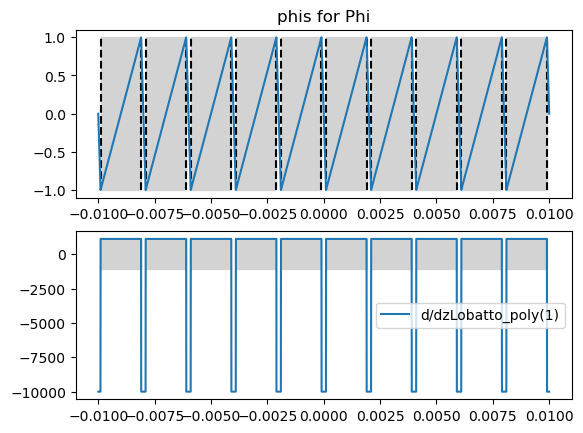

CG iteration 1, residual = 3.676635856473944     
CG iteration 2, residual = 5.045539473592277e-13     
-0.01


In [8]:

cl_Phi.numSheets = numSheets
cl_Phi.dFe = dFe
cl_Phi.d0 = d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 0

clPhi0 = cl_Phi(0, 0, material="outer|multiscale") #numSheets=1, d0=y_total/2, dFe=y_total/2, zstart=-y_total/2)
phi0 = clPhi0.phi



def calcMultiscale(useGradients=True):


    ex = CF((1, 0))



    # microshape functions
    orderPhi = [
        cl_Phi(1, fes_order=order0, material="multiscale"), 
        ]

    cl_Phi.plotEvaluated(orderPhi)

    VSpace = []
    # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="right|left")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material)))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
    sol_c = sol.components
    trial = VSpace.TrialFunction()
    test = VSpace.TestFunction()

    H_comp = []
    
    sol_pack = []
    sol_comp = []

    Energy_comp = []
                

    bfi_u = []
    bfi_v = []

    # phi 0 outer
    i = 0
    bfi_u += [[-grad(trial[i]), phi0]] # ok
    bfi_v += [[-grad(test[i]), phi0]]

    H_comp.append(-grad(sol_c[i]))
    sol_pack.append(sol_c[i] )
    sol_comp += [[sol_c[i], phi0]]
    Energy_comp += [[-grad(sol_c[i]), phi0]]

    ansatz += "-grad(Phi0_outer)"

    i += 1
    # Phi: grad(Phi*phi) = grad(Phi) * phi + Phi * dy phi ey
    for phi_i  in orderPhi:
        phi = phi_i.phi
        dxphi = phi_i.dzphi


        if useGradients:
            bfi_u += [[-grad(trial[i]), phi], [-trial[i]*ex,  dxphi]] # ok
            bfi_v += [[-grad(test[i]), phi], [-test[i]*ex,  dxphi]]
            H_comp.append(-(phi *grad(sol_c[i]) + dxphi*ex*sol_c[i]))
            Energy_comp += [[-grad(sol_c[i]), phi], [-sol_c[i]*ex, dxphi]]
        else:
            bfi_u += [[-trial[i]*ex,  dxphi]] # ok
            bfi_v += [[-test[i]*ex,  dxphi]]
            H_comp.append(-(dxphi*ex*sol_c[i]))
            Energy_comp += [[-sol_c[i]*ex, dxphi]]

        sol_pack.append(phi *sol_c[i])
        sol_comp += [[sol_c[i], phi]]
        
        ansatz += " - grad(Phi" + str(i) + " * "+ phi.name + ")"
    
        i +=1


    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a +=  lambda1  * grad(trial[0]) * grad(test[0]) * dx("outer")
    a +=  getIntegrand4BFI(bfi_u, bfi_v, lambda2, lambda1, dFe, d0, conductivity=True, force_num_int=True) * dx("multiscale")

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol_c[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)


    energy =  Integrate(getIntegrand4BFI(Energy_comp, Energy_comp, lambda2, lambda1, dFe, d0, conductivity=True), meshMS, definedon=meshMS.Materials("multiscale"))
    
    return sol, sol_pack, sol_comp, H_comp, energy, orderPhi

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, orderPhi = calcMultiscale(False)
print(orderPhi[0].zstart)

In [9]:
Draw(sum(sol_pack_MS) , meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

In [10]:
Draw(-lam * sum(H_comp)[0], meshRef, min = 0, max=150, settings={"Objects":{"Wireframe":False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [11]:
Draw(lam * grad(sol_ref)[0], meshRef, min = 0, max=150, settings={"Objects":{"Wireframe":False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [12]:
print("energy multiscale", energy_MS)
print("energy reference", energy_ref)

0.6083219796193374
0.5913785030403171
